# Basic Setup

Install common required packages

In [1]:
!pip3 install -U pandas numpy scikit-learn matplotlib

zsh:1: /Users/theopomies/projects/AI/data-science/templates/.venv/bin/pip3: bad interpreter: /Users/theopomies/projects/AI/data-science/.venv/bin/python: no such file or directory


Now we can import and rename them

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

Import the dataset

In [3]:
dataset_path = "./datasets/loans.csv" # replace, obviously

df = pd.read_csv(dataset_path)

# Discovery

In [4]:
# Lets familiarize ourselves with the data

print(df.shape)
print(df.info())
print(df.describe())
print(df.head())

# Lets visualize the target variable
print(df.Approval.value_counts())

(150302, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150302 entries, 0 to 150301
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Approval              150302 non-null  object 
 1   Debt-to-Income Ratio  150302 non-null  float64
 2   FICO Score            150302 non-null  int64  
 3   Request Amount        150302 non-null  int64  
 4   Interest              150302 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 5.7+ MB
None
       Debt-to-Income Ratio     FICO Score  Request Amount       Interest
count         150302.000000  150302.000000   150302.000000  150302.000000
mean               0.183538     672.023266    13427.080145    6042.186065
std                0.137226      69.129157     9468.345958    4260.755681
min                0.000000     371.000000      500.000000     225.000000
25%                0.090000     647.000000     6000.000000    2700.000000
50%

# Data Preparation

In [5]:
target_col = "Approval" # replace with the name of the target column

## Encode target variable (if needed)
We can use the LabelEncoder from sklearn.preprocessing to encode the target variable.

In [6]:
from sklearn.preprocessing import LabelEncoder

# Lets encode the target variable
label_encoder = LabelEncoder()
df[target_col] = label_encoder.fit_transform(df[target_col])

## Split the dataset

In [7]:
from sklearn.model_selection import train_test_split

# Remove rows with missing target, separate target from predictors
df.dropna(axis=0, subset=[target_col], inplace=True)

# Split dataset into training and test sets
X, X_test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=0)

# Separate target from predictors
y = X[target_col]
X = X.drop([target_col], axis=1)
y_test = X_test[target_col]
X_test = X_test.drop([target_col], axis=1)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

## Scoring function

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Categorical Features

In [9]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
[]


## Drop Features
The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.

**Be careful with missing values**

In [10]:
dropped_X_train = X_train.drop(columns=object_cols)
dropped_X_valid = X_valid.drop(columns=object_cols)

print(dropped_X_train.columns)
print(dropped_X_valid.columns)

Index(['Debt-to-Income Ratio', 'FICO Score', 'Request Amount', 'Interest'], dtype='object')
Index(['Debt-to-Income Ratio', 'FICO Score', 'Request Amount', 'Interest'], dtype='object')


## Ordinal Encoding
If the categories have an intrinsic order, we can use ordinal encoding.

Here, we can see that Approval is categorical, so we need to convert it to numerical
We can do this by using the LabelEncoder class from sklearn.preprocessing

In [11]:
from sklearn.preprocessing import OrdinalEncoder

# Copy to avoid changing the original dataset
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Lets encode the categorical variables
# ordinal_map = {"F": 0, "T": 1, np.nan: np.nan} # if you want to use a custom mapping
# ordinal_encoder = OrdinalEncoder(categories=[list(ordinal_map.keys())]) # if you want to use a custom mapping
ordinal_encoder = OrdinalEncoder() # if you want to use the default mapping
label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(label_X_valid[object_cols])

print(label_X_train.head())

        Debt-to-Income Ratio  FICO Score  Request Amount  Interest
1621                    0.01         503           20000    9000.0
36964                   0.18         748           25000   11250.0
8156                    0.03         699           21000    9450.0
113802                  0.15         684            3000    1350.0
72231                   0.58         688            2000     900.0


### One-Hot Encoding
If the categories do not have an intrinsic order, we can use one-hot encoding.

_One-hot encoding creates new columns indicating the presence (or absence) of each possible value in the  original data. To understand this, we'll work through an example._

In [12]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print(OH_X_train.head())

        Debt-to-Income Ratio  FICO Score  Request Amount  Interest
1621                    0.01         503           20000    9000.0
36964                   0.18         748           25000   11250.0
8156                    0.03         699           21000    9450.0
113802                  0.15         684            3000    1350.0
72231                   0.58         688            2000     900.0


/Users/theopomies/projects/AI/data-science/templates/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Find Best Encoding

In [13]:
print("MAE from Approach 1 (Drop columns with categorical values):")
print(score_dataset(dropped_X_train, dropped_X_valid, y_train, y_valid))

print("MAE from Approach 2 (Label Encoding):")
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

print("MAE from Approach 3 (One-Hot Encoding):")
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with categorical values):
0.21792913518026827
MAE from Approach 2 (Label Encoding):
0.21792913518026827
MAE from Approach 3 (One-Hot Encoding):
0.21792913518026827


## Missing Values

In [14]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

missing_val_columns = list(missing_val_count_by_column[missing_val_count_by_column > 0].index)

(96192, 4)
Series([], dtype: int64)


### Option 1: Drop
If too many missing values, drop the column

In [15]:
dropped_X_train = X_train.drop(columns=missing_val_columns)
dropped_X_valid = X_valid.drop(columns=missing_val_columns)

dropped_X_train.columns

Index(['Debt-to-Income Ratio', 'FICO Score', 'Request Amount', 'Interest'], dtype='object')

### Option 2: Impute
If not too many missing values, impute the missing values

In [16]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid)) # impute the validation data with the same imputer, fit on the training data

# This removes the column names, so we need to add them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

# Lets see if we have any missing values now
new_missing_val_count_by_column = (X_train.isnull().sum())
print(new_missing_val_count_by_column)


Debt-to-Income Ratio    0
FICO Score              0
Request Amount          0
Interest                0
dtype: int64


### Option 3: Impute with a new category
But I don't know yet how to do this

### Find Best Way to Handle Missing Values

In [17]:
print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(dropped_X_train, dropped_X_valid, y_train, y_valid))

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
0.21792913518026827
MAE from Approach 2 (Imputation):
0.21792913518026827


### Apply to Test Data

In [18]:
pass

# Model Selection

Once we have our model (RandomForest here), find the best parameters

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [20]:
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, X_train, X_valid, y_train, y_valid)
    print(f"Max leaf nodes: {max_leaf_nodes}  \t\t Mean Absolute Error:  {my_mae}")

Max leaf nodes: 5  		 Mean Absolute Error:  0.23949718914549487
Max leaf nodes: 50  		 Mean Absolute Error:  0.21618170043342042
Max leaf nodes: 500  		 Mean Absolute Error:  0.21373533753889937
Max leaf nodes: 5000  		 Mean Absolute Error:  0.2140777442110771


500 is the best here, so we'll go with that

# Build Model

In [21]:
model = DecisionTreeRegressor(max_leaf_nodes=500, random_state=0)

model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

DecisionTreeRegressor(max_leaf_nodes=500, random_state=0)

# Predict

In [22]:
y_pred = model.predict(X_test)

# Confusion Matrix

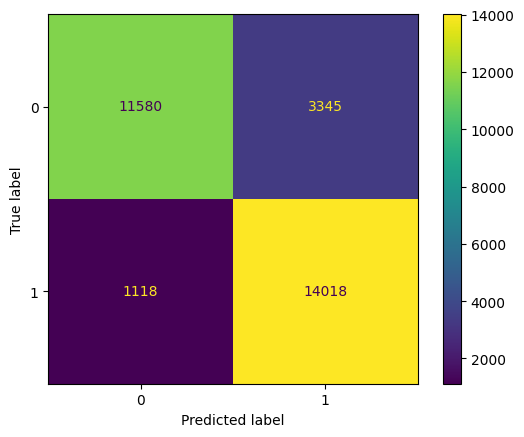

In [23]:
# Let's build a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = [1 if x > 0.5 else 0 for x in y_pred]

matrix = confusion_matrix(y_test, y_pred)
# display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)

disp.plot()


## Evaluate

In [24]:
tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()

accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Accuracy: 0.8515352117361366
Precision: 0.7758793969849246
Recall: 0.9119546385257521
F1: 0.8384317416645548
